##PROJECT DESCRIPTION

This project aims to predict the Relative Humidity (RH) of a household using a dataset. The dataset contains observations of a 5 month period: 11 January 2016 to 27 May 2016. The dataset is a combination of measurements of humidity and temperature from households and weather data. The house has 9 residual zones and Humidity and temperature of it has been measured every 10 minutes



## Exploratory data analysis

Importing the required modules



In [5]:
#importing the required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime as dt
import warnings
import time
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
warnings.filterwarnings('ignore')


## Reading the dataset and deriving useful time-related features

In [6]:

#reading the dataset
path_to_the_folder="/content/drive/MyDrive/EETBS 2021-2022/test_folder"
file_name="energydata_complete.csv"
path_to_the_file=os.path.join(path_to_the_folder,file_name)
my_DF=pd.read_csv(path_to_the_file,index_col=0,parse_dates=[0])
my_DF

#adding some extra columns derived from the date
my_DF.loc[:,"hour"]=my_DF.index.hour
my_DF.loc[:,"day of the week"]=my_DF.index.dayofweek


#adding weekend flag
my_DF.loc[my_DF.loc[:,"day of the week"]>4,"weekend"]=1
my_DF.loc[my_DF.loc[:,"day of the week"]<5,"weekend"]=0


#adding the working hours
my_DF.loc[:,"working hours"]=1
my_DF.loc[my_DF.loc[:,"day of the week"]>4,"working hours"]=0
my_DF.loc[my_DF.loc[:,"hour"]>17,"working hours"]=0
my_DF.loc[my_DF.loc[:,"hour"]<10,"working hours"]=0


#adding other data available from the date

my_DF.loc[:,"Month"]=my_DF.index.month


#generating some lagged columns to check if we can increase the correlation between the appliances and temperatures.


def laggedcolumncreator(df,parameter,lag_start,lag_end,lag_interval):
  for i in list(range(lag_start,lag_end,lag_interval)):
      laggedcolumn=parameter+"-"+str(i)+"min"
      df[laggedcolumn]=df[parameter].shift(i)
  return(df)

laggedcolumncreator(my_DF,"T1",20,121,20)
laggedcolumncreator(my_DF,"T2",20,121,20)
laggedcolumncreator(my_DF,"T3",20,121,20)
laggedcolumncreator(my_DF,"T4",20,121,20)
laggedcolumncreator(my_DF,"T5",20,121,20)
laggedcolumncreator(my_DF,"T6",20,121,20)
laggedcolumncreator(my_DF,"T7",20,121,20)
laggedcolumncreator(my_DF,"T8",20,121,20)
laggedcolumncreator(my_DF,"T9",20,121,20)
laggedcolumncreator(my_DF,"RH_1",20,121,20)
laggedcolumncreator(my_DF,"RH_2",20,121,20)
laggedcolumncreator(my_DF,"RH_3",20,121,20)
laggedcolumncreator(my_DF,"RH_4",20,121,20)
laggedcolumncreator(my_DF,"RH_5",20,121,20)
laggedcolumncreator(my_DF,"RH_6",20,121,20)
laggedcolumncreator(my_DF,"RH_7",20,121,20)
laggedcolumncreator(my_DF,"RH_8",20,121,20)
laggedcolumncreator(my_DF,"RH_9",20,121,20)

my_DF.dropna(inplace=True)
my_DF






,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,day of the week,weekend,working hours,Month,T1-20min,T1-40min,T1-60min,T1-80min,T1-100min,T1-120min,T2-20min,...,RH_3-60min,RH_3-80min,RH_3-100min,RH_3-120min,RH_4-20min,RH_4-40min,RH_4-60min,RH_4-80min,RH_4-100min,RH_4-120min,RH_5-20min,RH_5-40min,RH_5-60min,RH_5-80min,RH_5-100min,RH_5-120min,RH_6-20min,RH_6-40min,RH_6-60min,RH_6-80min,RH_6-100min,RH_6-120min,RH_7-20min,RH_7-40min,RH_7-60min,RH_7-80min,RH_7-100min,RH_7-120min,RH_8-20min,RH_8-40min,RH_8-60min,RH_8-80min,RH_8-100min,RH_8-120min,RH_9-20min,RH_9-40min,RH_9-60min,RH_9-80min,RH_9-100min,RH_9-120min
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12 13:00:00,60,0,20.166667,46.993333,19.200000,43.760000,19.890000,44.790000,19.890000,44.163333,17.890000,50.560000,7.500000,81.00,18.000000,39.590000,18.5000,47.126667,17.166667,44.626667,7.500000,743.5,79.000000,7.000000,40.000000,4.100000,49.591931,49.591931,13,1,0.0,1,1,19.760000,19.890000,20.566667,21.50,20.890000,19.89,18.963333,...,45.400000,45.790000,47.300000,44.730000,44.663333,46.70,46.000000,46.590000,49.947500,45.566667,50.900000,50.000000,50.090000,50.790000,79.000000,55.200000,95.396667,96.030000,92.866667,87.496667,87.530000,84.256667,41.966667,45.966667,45.966667,43.466667,42.333333,41.626667,49.663333,53.790000,54.900000,50.723333,50.230000,48.900000,46.163333,49.966667,47.826667,45.560000,45.126667,45.530000
2016-01-12 13:10:00,290,0,20.100000,46.430000,19.100000,43.817500,19.890000,44.790000,19.856667,44.160000,17.856667,50.730000,7.400000,80.36,17.890000,39.590000,18.5000,47.230000,17.166667,44.560000,7.416667,743.5,79.333333,7.166667,40.000000,4.066667,24.779679,24.779679,13,1,0.0,1,1,19.700000,19.890000,20.500000,21.39,20.963333,19.89,18.963333,...,45.466667,45.656667,47.026667,44.790000,44.590000,46.70,46.000000,46.790000,49.696667,45.992500,50.426667,50.126667,50.090000,50.663333,79.730000,55.200000,95.796667,95.900000,92.966667,87.896667,86.956667,84.063333,41.826667,45.900000,45.966667,43.626667,42.066667,41.560000,49.590000,53.760000,54.966667,50.963333,50.290000,48.863333,46.030000,50.000000,47.900000,45.626667,45.126667,45.560000
2016-01-12 13:20:00,130,0,20.100000,46.030000,19.100000,43.838125,19.890000,44.790000,19.856667,44.026667,17.856667,50.863333,7.466667,80.36,17.890000,39.590000,18.5000,47.290000,17.100000,44.500000,7.333333,743.5,79.666667,7.333333,40.000000,4.033333,24.217476,24.217476,13,1,0.0,1,1,19.700000,19.890000,20.500000,21.39,21.033333,19.89,18.890000,...,45.400000,45.663333,46.826667,44.933333,44.693333,46.70,46.030000,46.790000,49.166667,45.890000,49.930000,50.200000,50.090000,50.530000,79.256667,55.090000,96.260000,95.966667,93.093333,88.633333,86.563333,83.156667,41.663333,45.826667,46.200000,43.760000,43.633333,41.433333,49.466667,53.700000,55.090000,51.163333,50.163333,48.730000,45.863333,50.000000,48.030000,45.700000,45.060000,45.500000
2016-01-12 13:30:00,140,0,20.066667,45.363333,19.100000,43.745000,19.890000,44.863333,19.790000,43.863333,17.790000,50.933333,7.656667,78.79,17.890000,39.590000,18.5000,47.330000,17.100000,44.400000,7.250000,743.5,80.000000,7.500000,40.000000,4.000000,8.672117,8.672117,13,1,0.0,1,1,19.700000,19.890000,20.426667,21.29,21.100000,19.89,18.890000,...,45.400000,45.590000,46.633333,45.000000,45.026667,46.79,46.163333,46.933333,48.426667,45.723333,49.656667,50.230000,50.030000,50.500000,78.393333,55.090000,96.466667,95.933333,94.045000,89.026667,86.330000,83.423333,41.590000,45.722500,46.200000,43.933333,43.633333,41.290000,49.400000,53.875000,55.030000,51.500000,50.030000,48.590000,45.730000,50.000000,48.090000,45.790000,45.000000,45.400000
2016-01-12 13:40:00,240,0,20.000000,44.963333,19.100000,43.595556,19.890000,44.826667,19.730000,43.530000,17.790000,51.000000,7.530000,78.19,17.890000,39.590000,18.5000,47.282500,17.100000,44.326667,7.1

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Visualizing And Exploring Dataset

In this part, lagged columns are added for temperature and relative humidity.
Lagged columns are started from 20 minutes and ended at 120 minutes. Moreover, the time interval of the lagged columns are 20 minutes. 
These coulumns gives us detailed data which leads to more pricese results.

In [ ]:
my_DF.corr().style.background_gradient(cmap="Blues")

## Feature engineering/extraction
Defining the required functions for performing the feature selection


In [7]:

def WAPE (y_true, y_pred):
    import numpy as np
    df_y_true=y_true.copy()
    df_y_pred=y_pred.copy()
    df_y_pred.columns=df_y_true.columns
    WAPE=100*np.sum(np.abs(df_y_pred - df_y_true))/np.sum(np.abs(df_y_true))
    return  round(WAPE[0],2)



def acc_timeseriessplit(X,y,model,cv):
  tscv = TimeSeriesSplit(n_splits=cv)
  acc = []
  for train_index, valid_index in tscv.split(X):
    #print("TRAIN:", len(train_index), "TEST:", len(valid_index))
    
    X_train, X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    y_train, y_valid = y.iloc[train_index,:], y.iloc[valid_index,:]

    model.fit(X_train, y_train)
    y_valid_predicted=pd.DataFrame(index=y_valid.index)
    y_valid_predicted['pred'] = model.predict(X_valid)
    #y_valid_predicted = y_valid_predicted.reshape(len(y_valid_predicted),1)
    accuracy =WAPE(y_valid,y_valid_predicted)
    acc.append(accuracy)
  return np.average(acc)


def plot_y_feat (WAPE_features , plt_name = 'Name [-]' ):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.path as mpath
    import numpy as np
    
    plt.figure(1,figsize=(13,5))
    plt.style.use('seaborn-whitegrid')
    plt.axis ('auto')
    plt.plot(np.arange(len(WAPE_features.index)), np.array(WAPE_features), color = 'blue',  markersize = 5, linestyle = '-')
    plt.xticks(np.arange(len(WAPE_features.index)),WAPE_features.index, rotation=40, fontsize=8,horizontalalignment="right", wrap=True)
    plt.ylabel('WAPE [%]', wrap=True)
    fig = plt.figure(1)
    fig.canvas.set_window_title(plt_name)
    
    

def feature_sel_1 (estimator,Features,Target,Save_address,cv=10):
  import pandas as pd
  from sklearn.model_selection import cross_val_predict
  import matplotlib as mpl
  import matplotlib.pyplot as plt
  import os
  # Find the correlation matrix, and find the abs(correlation) of each feature with the target
  correlation = abs((pd.concat((Features,Target), axis = 1).corr())[Target.columns[0]]).sort_values(ascending=False).dropna().drop(Target.columns[0])
  correlation_list  = list(correlation.index) 

  # Order the features based on the corresponding correlation
  DF_Features=pd.DataFrame(index = Features.index)
  FeatureSelection = pd.Series(index = correlation_list) 
  for feat in correlation_list:
    DF_Features= pd.concat((DF_Features, Features[feat]), axis=1)
    FeatureSelection[feat]=acc_timeseriessplit(DF_Features,Target,estimator,cv)

  #choose the set of features which leads to minimum WAPE
  FeatureSelection_selected = FeatureSelection[:(str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",''))]   

  #among the remaining features, the ones that increase the overall obtained error are discarded
  FeatureSelection_neg = FeatureSelection 

  for feat in  correlation_list[1:]:
      if ((FeatureSelection.shift(+1)).loc[feat]) >= (FeatureSelection.loc[feat]): 
          continue
      else:
          FeatureSelection_neg = FeatureSelection_neg.drop([feat])

  FeatureSelection_neg_after = FeatureSelection_neg[(str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",'')):].drop((str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",'')))
  
  #the remaining ones are sorted in a descending order based on the overall error obtained while adding them.
  FeatureSelection_selected = pd.concat((FeatureSelection_neg_after.sort_values(ascending=False),FeatureSelection_selected.sort_values(ascending=False)), axis = 0)
  #Plot and save the figure
  plt_name ='selected_features_step1'+'.png'
  plot_y_feat(FeatureSelection , plt_name = plt_name)
  plt.savefig(os.path.join(Save_address,plt_name), dpi = (400))

  return FeatureSelection_selected

def feature_sel_2(estimator,Features,Target,FeatureSelection,Save_address,cv=10):
  import matplotlib as mpl
  import matplotlib.pyplot as plt
  import os

  #Selection of the features according to their WAPE
  import pandas as pd
  from sklearn.model_selection import cross_val_predict
  DF_features_selected = Features[FeatureSelection.index]
  #reverse the order of columns
  DF_features_selected=DF_features_selected.iloc[:, ::-1]


  #same as previous step features are added gradually and the obtained WAPE is monitored
  FeatureSelection = pd.Series(index = DF_features_selected.columns) 
  DF_Features=pd.DataFrame(index = Features.index)
  for feat in DF_features_selected.columns:
    DF_Features= pd.concat((DF_Features, DF_features_selected[feat]), axis=1)
    FeatureSelection[feat]=acc_timeseriessplit(DF_Features,Target,estimator,cv)
  #Selecting the set of features which leads to minmum WAPE
  FeatureSelection_selected_updated = FeatureSelection[:(str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",''))]          
  
  
  #Plot and save the figure
  plt_name ='selected_features_step2'+'.png'
  plot_y_feat(FeatureSelection , plt_name = plt_name)
  plt.savefig(os.path.join(Save_address,plt_name), dpi = (400))

  return FeatureSelection_selected_updated



def feature_sel_3(algorithm,Features,Target,FeatureSelection,Save_address,cv=10):
  import matplotlib as mpl
  import matplotlib.pyplot as plt
  import os
  import pandas as pd
  from sklearn.model_selection import cross_val_predict
  DataSet_features=Features[FeatureSelection.index]

  DF_features=DataSet_features.copy()
  features=pd.DataFrame(index=DataSet_features.index)
  Final_WAPE_results=pd.Series()

  for i in range(len(DataSet_features.columns)) :
    WAPE_values_this_iter=pd.Series()
    for feat in DF_features.columns :
      features=pd.concat((features,DataSet_features[feat]),axis=1)
      WAPE_values_this_iter[feat]=acc_timeseriessplit(features,Target,algorithm,cv)
      features=features.drop(feat,axis=1)
      
    features=pd.concat((features,DataSet_features[WAPE_values_this_iter.idxmin()]),axis=1)
    DF_features=DF_features.drop(WAPE_values_this_iter.idxmin(),axis=1)
    Final_WAPE_results[WAPE_values_this_iter.idxmin()]=WAPE_values_this_iter.min()
    


  FeatureSelection_final = Final_WAPE_results[:(str(Final_WAPE_results[(Final_WAPE_results == Final_WAPE_results.min())].index.values.tolist()).replace("['",'').replace("']",''))]          
  DF_features_selected_Final = DataSet_features[FeatureSelection_final.index]
 
  #Plot and save the figure
  plt_name ='selected_features_step3'+'.png'
  plot_y_feat(Final_WAPE_results)
  plt.savefig(os.path.join(Save_address,plt_name), dpi = (400))

  return DF_features_selected_Final

##Feature Selection

In this section, feature selection is performed using Random Farest algorithm and three different selection types.

In [8]:
y=my_DF[["RH_1"]]
X=my_DF.drop(columns=["RH_1"])

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)# The last 20% is used as the test, without shuffling

concat_DF=pd.concat((X_train_val,y_train_val),axis=1) 

concat_DF

correlation_vect=abs(concat_DF.corr()["RH_1"])
correlation_vect_sorted=correlation_vect.sort_values (ascending=False)
correlation_vect_sorted=correlation_vect_sorted.drop("RH_1")
A=correlation_vect_sorted>0.7

correlation_vect_edited=correlation_vect_sorted[A]
correlation_vect_edited.index

X_train_val=X_train_val[correlation_vect_edited.index]

X_test=X_test[correlation_vect_edited.index]


#having defined the viable features to be chosen, the three available selection methods are evaluated in the following.

path_to_Save="/content/drive/MyDrive/EETBS 2021-2022/Feature_Selection_Results"
warnings.filterwarnings('ignore')

#implementing the feature selection using Random Forest algorithm
from sklearn.ensemble import RandomForestRegressor
RF_reg = RandomForestRegressor()


cv=10
#featureSelection_1= feature_sel_1(RF_reg,X_train_val, y_train_val, path_to_Save,cv)


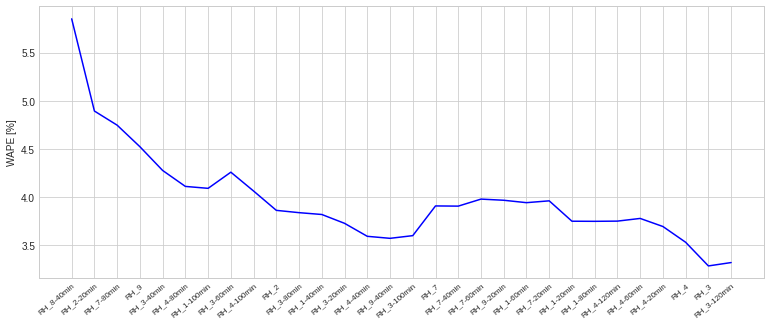

In [ ]:
feature_selection_2 = feature_sel_2(RF_reg,X_train_val,y_train_val,featureSelection_1,path_to_Save, cv)

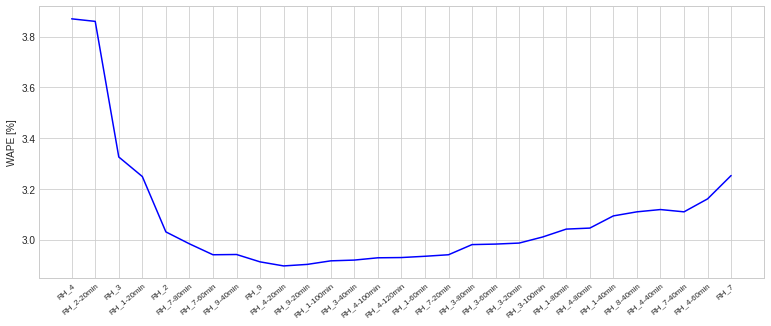

In [ ]:
df_selected_features = feature_sel_3(RF_reg,X_train_val,y_train_val,feature_selection_2, path_to_Save,cv)

In [9]:
selected_features=["RH_4" , "RH_2-20min" ,"RH_3", "RH_1-20min" , "RH_2", "RH_7-80min" ,"RH_7-60min","RH_9-40min", "RH_9","RH_4-20min"]
WAPE_sel_feat_val  = acc_timeseriessplit(X_train_val[selected_features],y_train_val,RF_reg,cv)
RF_reg.fit(X_train_val[selected_features],y_train_val)
y_test_predicted_sel_feat= pd.DataFrame(index=y_test.index)
y_test_predicted_sel_feat["real"] = y_test["RH_1"]
y_test_predicted_sel_feat["pred"] = RF_reg.predict(X_test[selected_features])
WAPE_sel_feat_test= WAPE(y_test_predicted_sel_feat[["real"]],y_test_predicted_sel_feat[["pred"]])





df_accuracy = pd.DataFrame(columns=["Validation","Test","Features"])
df_accuracy.loc["Selected Feature","Test"] = WAPE_sel_feat_test
df_accuracy.loc["Selected Feature","Validation"]= WAPE_sel_feat_val
df_accuracy.loc["Selected Feature","Features"]= str(list(selected_features))



In [ ]:
df_accuracy

,Validation,Test,Features
Selected Feature,2.913,3.7,"['RH_4', 'RH_2-20min', 'RH_3', 'RH_1-20min', '..."


##Linear Regression

In [10]:
#choosing targets and features

target=my_DF["RH_1"]
features=selected_features

#choosing the test,validation and trainining data

test_target=y_test
test_features=X_test[selected_features]

training_DF=X_train_val[selected_features].loc["2016-01-12":"2016-03-30"]

validation_DF=X_train_val[selected_features].loc["2016-04-01":"2016-04-30"]

In [11]:
#fitting linear regression on the data

from sklearn import linear_model
linear_reg=linear_model.LinearRegression()
training_target=y_train_val.loc["2016-01-12":"2016-03-30"]
training_features=training_DF

linear_reg.fit(training_features,training_target)

LinearRegression()

In [12]:
#creating the validation features and target

validation_target=y_train_val.loc["2016-04-01":"2016-04-30"]

validation_features=validation_DF

predicted_RH_1_validation_LR=linear_reg.predict(validation_features)

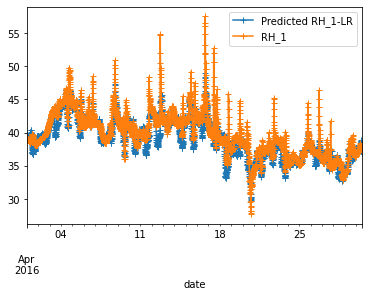

In [13]:
#comparing the real value with the validated data

Comparison_DF=pd.DataFrame(predicted_RH_1_validation_LR,index=validation_target.index,columns=["Predicted RH_1-LR"])

Comparison_DF=Comparison_DF.join(validation_target)

Comparison_DF.plot(marker="+")

In [14]:
#calculating the performance metrics

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_LR_validation=mean_absolute_error(predicted_RH_1_validation_LR,validation_target)
MSE_LR_validation=mean_squared_error(predicted_RH_1_validation_LR,validation_target)
R2_LR_validation=r2_score(predicted_RH_1_validation_LR,validation_target)

print("MAE_LR: "+str(round(MAE_LR_validation,2))+" MSE_LR: "+str(round(MSE_LR_validation,2))+" R2 Score_LR: "+str(round(R2_LR_validation,4)))



MAE_LR: 1.01 MSE_LR: 2.32 R2 Score_LR: 0.7297


##Random Forest

In [15]:
#applying Random Forest Model

from sklearn.ensemble import RandomForestRegressor
RF_reg = RandomForestRegressor()



In [16]:
RF_reg.fit(training_features,training_target)
predicted_RH_1_validation_RF = RF_reg.predict(validation_features)

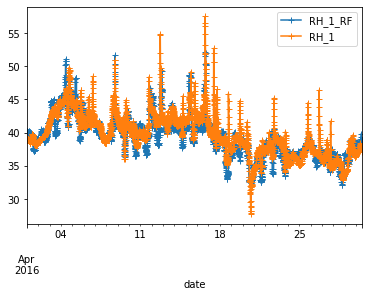

In [17]:
#comparing the real values compared with the ones estimated by RF_reg

Comparison_DF_RF=pd.DataFrame(predicted_RH_1_validation_RF,index=validation_target.index,columns=["RH_1_RF"])
Comparison_DF_RF=Comparison_DF_RF.join(validation_target)
Comparison_DF_RF.plot(marker="+")

In [18]:
##calculating the performance metrics

MAE_RF_validation=mean_absolute_error(predicted_RH_1_validation_RF,validation_target)
MSE_RF_validation=mean_squared_error(predicted_RH_1_validation_RF,validation_target)
R2_RF_validation=r2_score(predicted_RH_1_validation_RF,validation_target)

print("MAE_LR: "+str(round(MAE_RF_validation,2))+" MSE_RF: "+str(round(MSE_RF_validation,2))+" R2 Score_RF: "+str(round(R2_RF_validation,4)))




MAE_LR: 1.2 MSE_RF: 2.84 R2 Score_RF: 0.6818


##XGboost

In [19]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100,max_depth=7,eta=0.1,subsample=0.7,colsample_bytree=0.8,silent=1)



model.fit(training_features,training_target)
predicted_RH_1_validation_XGboost=model.predict(validation_features)

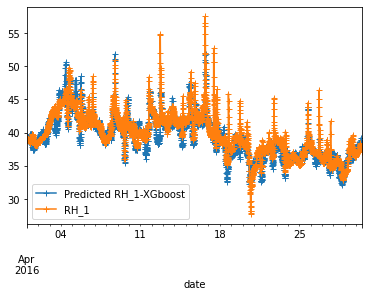

In [20]:
Comparison_DF=pd.DataFrame(predicted_RH_1_validation_XGboost,index=validation_target.index,columns=["Predicted RH_1-XGboost"])

Comparison_DF=Comparison_DF.join(validation_target)

Comparison_DF.plot(marker="+")

In [21]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_XG_validation=mean_absolute_error(predicted_RH_1_validation_XGboost,validation_target)
MSE_XG_validation=mean_squared_error(predicted_RH_1_validation_XGboost,validation_target)
R2_XG_validation=r2_score(predicted_RH_1_validation_XGboost,validation_target)

print("MAE_LR: "+str(round(MAE_XG_validation,2))+" MSE_LR: "+str(round(MSE_XG_validation,2))+" R2 Score_LR: "+str(round(R2_XG_validation,4)))

MAE_LR: 1.04 MSE_LR: 2.17 R2 Score_LR: 0.7751


##Having analyzed the performance matrices, XGboost is chosen as the promising model and the model is fitted for the test section

In [22]:
model.fit(X_train_val[selected_features],y_train_val)
predicted_RH_1_test=model.predict(X_test[selected_features])

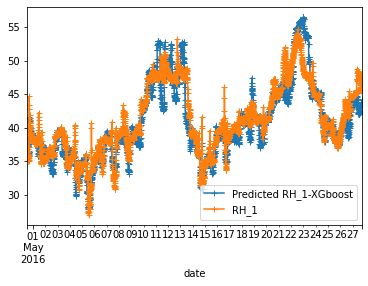

In [23]:
Comparison_DF=pd.DataFrame(predicted_RH_1_test,index=test_target.index,columns=["Predicted RH_1-XGboost"])
Comparison_DF=Comparison_DF.join(test_target)
Comparison_DF.plot(marker="+")

In [24]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_XGT_validation=mean_absolute_error(predicted_RH_1_test,test_target)
MSE_XGT_validation=mean_squared_error(predicted_RH_1_test,test_target)
R2_XGT_validation=r2_score(predicted_RH_1_test,test_target)

print("MAE_LR: "+str(round(MAE_XGT_validation,2))+" MSE_LR: "+str(round(MSE_XGT_validation,2))+" R2 Score_LR: "+str(round(R2_XGT_validation,4)))


MAE_LR: 1.5 MSE_LR: 4.66 R2 Score_LR: 0.8467


##The same procedure is performend without feature selection and the results are compared.


##Linear Regression

In [25]:
y=my_DF[["RH_1"]]
X=my_DF.drop(columns=["RH_1"])

In [26]:
#choosing targets and features

target=my_DF["RH_1"]
features=my_DF.drop("RH_1", axis=1)

#choosing the test,validation and trainining data

test_target=y_test
test_features=X_test

training_DF=X_train_val.loc["2016-01-12":"2016-03-30"]

validation_DF=X_train_val.loc["2016-04-01":"2016-04-30"]

In [27]:
#fitting linear regression on the data

from sklearn import linear_model
linear_reg=linear_model.LinearRegression()
training_target=y_train_val.loc["2016-01-12":"2016-03-30"]
training_features=training_DF

linear_reg.fit(training_features,training_target)

LinearRegression()

In [28]:
#creating the validation features and target

validation_target=y_train_val.loc["2016-04-01":"2016-04-30"]
validation_features=validation_DF

predicted_RH_1_validation_LR1=linear_reg.predict(validation_features)

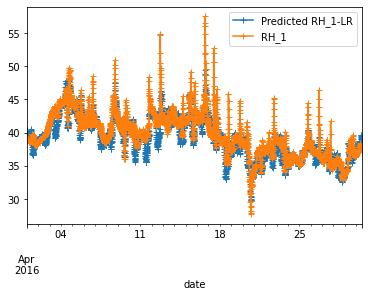

In [29]:
#comparing the real value with the validated data

Comparison_DF=pd.DataFrame(predicted_RH_1_validation_LR1,index=validation_target.index,columns=["Predicted RH_1-LR"])

Comparison_DF=Comparison_DF.join(validation_target)

Comparison_DF.plot(marker="+")

In [30]:
#calculating the performance metrics

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_LR1_validation=mean_absolute_error(predicted_RH_1_validation_LR1,validation_target)
MSE_LR1_validation=mean_squared_error(predicted_RH_1_validation_LR1,validation_target)
R2_LR1_validation=r2_score(predicted_RH_1_validation_LR1,validation_target)

print("MAE_LR: "+str(round(MAE_LR1_validation,2))+" MSE_LR: "+str(round(MSE_LR1_validation,2))+" R2 Score_LR: "+str(round(R2_LR1_validation,4)))



MAE_LR: 0.96 MSE_LR: 2.13 R2 Score_LR: 0.7655


##Random Forest

In [31]:
#applying Random Forest Model

from sklearn.ensemble import RandomForestRegressor
RF_reg = RandomForestRegressor()



In [32]:
RF_reg.fit(training_features,training_target)
predicted_RH_1_validation_RF1 = RF_reg.predict(validation_features)

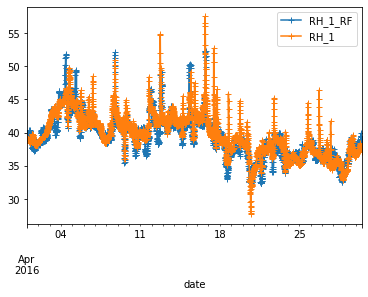

In [33]:
#comparing the real values compared with the ones estimated by RF_reg

Comparison_DF_RF=pd.DataFrame(predicted_RH_1_validation_RF1,index=validation_target.index,columns=["RH_1_RF"])
Comparison_DF_RF=Comparison_DF_RF.join(validation_target)
Comparison_DF_RF.plot(marker="+")

In [34]:
##calculating the performance metrics

MAE_RF1_validation=mean_absolute_error(predicted_RH_1_validation_RF1,validation_target)
MSE_RF1_validation=mean_squared_error(predicted_RH_1_validation_RF1,validation_target)
R2_RF1_validation=r2_score(predicted_RH_1_validation_RF1,validation_target)

print("MAE_LR: "+str(round(MAE_RF1_validation,2))+" MSE_RF: "+str(round(MSE_RF1_validation,2))+" R2 Score_RF: "+str(round(R2_RF1_validation,4)))




MAE_LR: 1.15 MSE_RF: 2.64 R2 Score_RF: 0.7195


##XGboost

In [35]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100,max_depth=7,eta=0.1,subsample=0.7,colsample_bytree=0.8,silent=1)



model.fit(training_features,training_target)
predicted_RH_1_validation=model.predict(validation_features)

In [36]:
validation_target=y_train_val.loc["2016-04-01":"2016-04-30"]
validation_features=validation_DF

predicted_RH_1_validation_XGboost1=model.predict(validation_features)



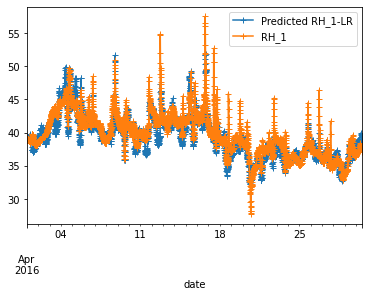

In [37]:
Comparison_DF=pd.DataFrame(predicted_RH_1_validation_XGboost1,index=validation_target.index,columns=["Predicted RH_1-LR"])

Comparison_DF=Comparison_DF.join(validation_target)

Comparison_DF.plot(marker="+")

In [38]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_XG1_validation=mean_absolute_error(predicted_RH_1_validation_XGboost1,validation_target)
MSE_XG1_validation=mean_squared_error(predicted_RH_1_validation_XGboost1,validation_target)
R2_XG1_validation=r2_score(predicted_RH_1_validation_XGboost1,validation_target)

print("MAE_XG1: "+str(round(MAE_XG1_validation,2))+" MSE_XG1: "+str(round(MSE_XG1_validation,2))+" R2 Score_XG1: "+str(round(R2_XG1_validation,4)))

MAE_XG1: 1.07 MSE_XG1: 2.24 R2 Score_XG1: 0.765


In [39]:
#fitting the target with XGboost

model.fit(X_train_val,y_train_val)
predicted_RH_1_test_1=model.predict(X_test)





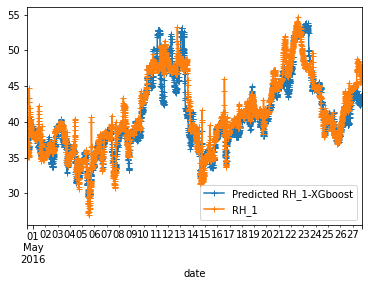

In [40]:
Comparison_DF=pd.DataFrame(predicted_RH_1_test_1,index=test_target.index,columns=["Predicted RH_1-XGboost"])
Comparison_DF=Comparison_DF.join(test_target)
Comparison_DF.plot(marker="+")

In [41]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_XGT1_validation=mean_absolute_error(predicted_RH_1_test_1,test_target)
MSE_XGT1_validation=mean_squared_error(predicted_RH_1_test_1,test_target)
R2_XGT1_validation=r2_score(predicted_RH_1_test_1,test_target)

print("MAE_XGT1: "+str(round(MAE_XGT1_validation,2))+" MSE_XGT1: "+str(round(MSE_XGT1_validation,2))+" R2 Score_XGT1: "+str(round(R2_XGT1_validation,4)))


MAE_XGT1: 1.39 MSE_XGT1: 3.84 R2 Score_XGT1: 0.8586


##Having performed all the steps, the derived parameters are now compared.

In [42]:
import plotly.graph_objects as go

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Performance Metrics</b>','<b>SF_LR</b>','<b>SF_RF</b>','<b>SF_XG</b>','<b>Target_XG</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      ['MAE', 'MSE', 'R2 Score'],
      [MAE_LR_validation,MSE_LR_validation ,R2_LR_validation],
     [MAE_RF_validation,MSE_RF_validation ,R2_RF_validation],
      [MAE_XG_validation,MSE_XG_validation ,R2_XG_validation],
      [MAE_XGT_validation,MSE_XGT_validation ,R2_XGT_validation]],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.show()

In [43]:
import plotly.graph_objects as go

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Performance Metrics</b>','<b>AF_LR</b>','<b>AF_RF</b>','<b>AF_XG</b>','<b>Target_XG</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      ['MAE', 'MSE', 'R2 Score'],
      [MAE_LR1_validation,MSE_LR1_validation ,R2_LR1_validation],
     [MAE_RF1_validation,MSE_RF1_validation ,R2_RF1_validation],
      [MAE_XG1_validation,MSE_XG1_validation ,R2_XG1_validation],
      [MAE_XGT1_validation,MSE_XGT1_validation ,R2_XGT1_validation]],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.show()

##In the following, the value of WAPE is calculated for the exploited models (using both the selected features and all the features)

In [44]:

selected_features=["RH_4" , "RH_2-20min" ,"RH_3", "RH_1-20min" , "RH_2", "RH_7-80min" ,"RH_7-60min","RH_9-40min", "RH_9","RH_4-20min"]
WAPE_sel_feat_val_LR  = acc_timeseriessplit(X_train_val[selected_features],y_train_val,linear_reg,cv)
WAPE_sel_feat_val_RF  = acc_timeseriessplit(X_train_val[selected_features],y_train_val,RF_reg,cv)
WAPE_sel_feat_val_XGboost  = acc_timeseriessplit(X_train_val[selected_features],y_train_val,model,cv)

In [45]:
WAPE_sel_feat_val_LR_allfeatures  = acc_timeseriessplit(X_train_val,y_train_val,linear_reg,cv)
WAPE_sel_feat_val_RF_allfeatures  = acc_timeseriessplit(X_train_val,y_train_val,RF_reg,cv)
WAPE_sel_feat_val_XGboost_allfeatures  = acc_timeseriessplit(X_train_val,y_train_val,model,cv)

In [46]:
#The derived values ar then represnted in a dataframe
import plotly.graph_objects as go

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Model</b>','<b>WAPE_Selected features</b>','<b>WAPE_All features</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      ['LR', 'RF', 'XGboost'],
      [WAPE_sel_feat_val_LR,WAPE_sel_feat_val_RF ,WAPE_sel_feat_val_XGboost ],
       [WAPE_sel_feat_val_LR_allfeatures,WAPE_sel_feat_val_RF_allfeatures ,WAPE_sel_feat_val_XGboost_allfeatures ]
    ],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.show()

##In the Following the predicted data using XGboost algorithm is compared to the real data.

In [47]:
y_test_pred_selected_feat= pd.DataFrame(index=y_test.index)
y_test_pred_selected_feat["real"]=y_test["RH_1"]
y_test_pred_selected_feat["pred"]=predicted_RH_1_test


In [48]:
y_test_pred_all_feat= pd.DataFrame(index=y_test.index)
y_test_pred_all_feat["real"]=y_test["RH_1"]
y_test_pred_all_feat["pred"]=predicted_RH_1_test_1


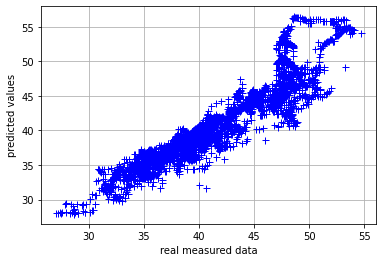

In [49]:


plt.plot(y_test_pred_selected_feat["real"],y_test_pred_selected_feat["pred"],"+", color="b",markersize=7)
plt.xlabel("real measured data")
plt.ylabel("predicted values")
plt.grid()

In [52]:
!pip install tpot

     |████████████████████████████████| 87 kB 3.9 MB/s 
     |████████████████████████████████| 160 kB 42.5 MB/s 
     |████████████████████████████████| 173.6 MB 10 kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=dd0b620877a6f9c0e9d446f34461e0d1d3222cce701f4521d3e6819e2d56e6ca
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


##Implementing the algorithm suggested by T-pot

In [53]:
from tpot import TPOTRegressor
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = my_DF
features = tpot_data.drop("RH_1", axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data["RH_1"], random_state=None)

# Average CV score on the training set was: -2.0789999999999997
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    RobustScaler(),
    StackingEstimator(estimator=DecisionTreeRegressor(max_depth=1, min_samples_leaf=5, min_samples_split=20)),
    RidgeCV()
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)



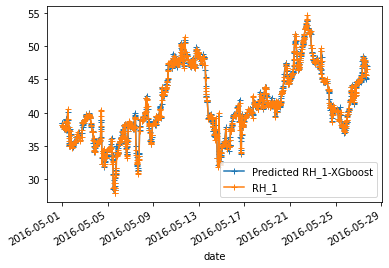

In [55]:
Comparison_DF=pd.DataFrame(results,index=testing_target.index,columns=["Predicted RH_1-XGboost"])
Comparison_DF=Comparison_DF.join(testing_target)
Comparison_DF.loc["2016-05-01":"2016-05-27"].plot(marker="+")


In [56]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_RCV_validation=mean_absolute_error(results,testing_target)
MSE_RCV_validation=mean_squared_error(results,testing_target)
R2_RCV_validation=r2_score(results,testing_target)

print("MAE_LR: "+str(round(MAE_RCV_validation,2))+" MSE_LR: "+str(round(MSE_RCV_validation,2))+" R2 Score_LR: "+str(round(R2_RCV_validation,4)))

MAE_LR: 0.29 MSE_LR: 0.3 R2 Score_LR: 0.9803
